# Mapper on Fashion MNIST Data



In [ ]:
import os
import hdbscan
import matplotlib.pyplot as plt
from mnist import MNIST
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import umap

import kmapper as km
from kmapper import jupyter
from kmapper import adapter

In [31]:
%matplotlib inline
sns.set(style='white', context='poster')

save = False
save_root = "redo/images/"

In [33]:
classes = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
]

In [34]:
mndata = MNIST('/Users/cartman/development/data/fashion')
# mndata.gz = True
train, train_labels = mndata.load_training()
test, test_labels = mndata.load_testing()
data = np.array(np.vstack([train, test]), dtype=np.float64) / 255.0
target = np.hstack([train_labels, test_labels])
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=0.1, random_state=42)

In [35]:
data_train.shape

(63000, 784)

# Reduce dimensionality of image space

Not really necessary, but can help the modeling in later steps.

In [36]:
p = PCA(n_components=100)
reduced_data_train = p.fit_transform(data_train)
reduced_data_test = p.transform(data_test)

# Train a model

In [1]:
lr = LogisticRegression(penalty='l1')
%time lr.fit(reduced_data_train, target_train)

NameError: name 'LogisticRegression' is not defined

In [38]:
lr.score(reduced_data_train, target_train), lr.score(reduced_data_test, target_test)

(0.8493015873015873, 0.842)

In [40]:
lens_train = lr.decision_function(reduced_data_train)

mapper_ids = np.array(list(range(len(lens_train)))) 
mapper_reduced_data = reduced_data_train[mapper_ids]
mapper_lens = lens_train[mapper_ids]
mapper_view_data = data_train[mapper_ids]
mapper_labels = target_train[mapper_ids]

mapper_lbls = [classes[i] for i in mapper_labels]

# Dimensionality reduction of prediction space

Comparing UMAP vs PCA.

In [42]:
u = umap.UMAP(n_neighbors=5)
lens = u.fit_transform(mapper_lens)

In [43]:
lens2 = PCA(n_components=2).fit_transform(mapper_lens)

(63000, 2)

In [45]:
model = lr

def render(i, ax=None):
    ax = ax if ax else plt.gca()
    I = mapper_view_data[i].reshape((28,28))
    I = np.ma.masked_array(I, I==0)
    
    ax.imshow(I, cmap='binary', vmin=0, vmax=1)
    ax.axis("off")
    return ax

def reduced_scatter(lens, ax=None):
    ax = ax or plt.gca()
    
    plt.scatter(*lens.T, s=0.1, c=mapper_labels, cmap='Spectral', alpha=1.0)
    plt.setp(ax, xticks=[], yticks=[])
    cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
    cbar.set_ticks(np.arange(10))
    cbar.set_ticklabels(classes)

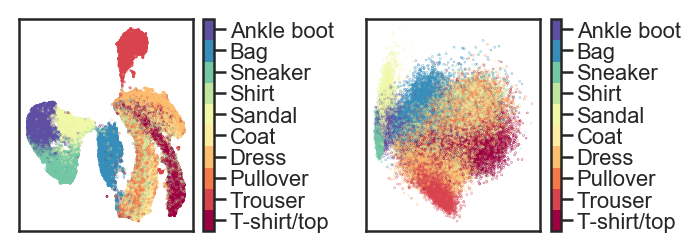

In [46]:
plt.figure(figsize=(10,4))
ax = plt.subplot(121)
reduced_scatter(lens, ax)

ax = plt.subplot(122)
reduced_scatter(lens2, ax)

plt.tight_layout()

In [48]:
lens2 = MinMaxScaler().fit_transform(lens)
graph = km.KeplerMapper(verbose=1).map(lens2, reduced_data_train,
                                       clusterer=km.cluster.DBSCAN(10),
                                       cover=km.Cover(n_cubes=40, perc_overlap=.5),
                                       nerve=km.GraphNerve(min_intersection=1))
# html = km.KeplerMapper().visualize(graph, color_function=mapper_labels)#, custom_tooltips=mapper_lbls)


KeplerMapper()
Mapping on data shaped (63000, 100) using lens shaped (63000, 2)

Creating 1600 hypercubes.

Created 2678 edges and 779 nodes in 0:00:13.086408.


In [50]:
nx_graph = adapter.to_networkx(graph)

edge_members = {}
for start, ends in graph['links'].items():
    for end in ends:
        members = set(nx_graph.nodes[start]['membership']).intersection(nx_graph.nodes[end]['membership'])
        edge_members[(start, end)] = list(members)
        

nx.set_edge_attributes(nx_graph, edge_members, "membership")

small_components = [c for cc in nx.connected_components(nx_graph) for c in cc if len(cc) < 3]
nx_graph.remove_nodes_from(small_components)

# pos = nx.drawing.spring_layout(nx_graph)
# cc = sorted([c for c in nx.connected_components(nx_graph)], key=len, reverse=True)[0]
# cc_sub = nx.subgraph(nx_graph, cc)
cc_sub = nx_graph

pos = graphviz_layout(cc_sub)

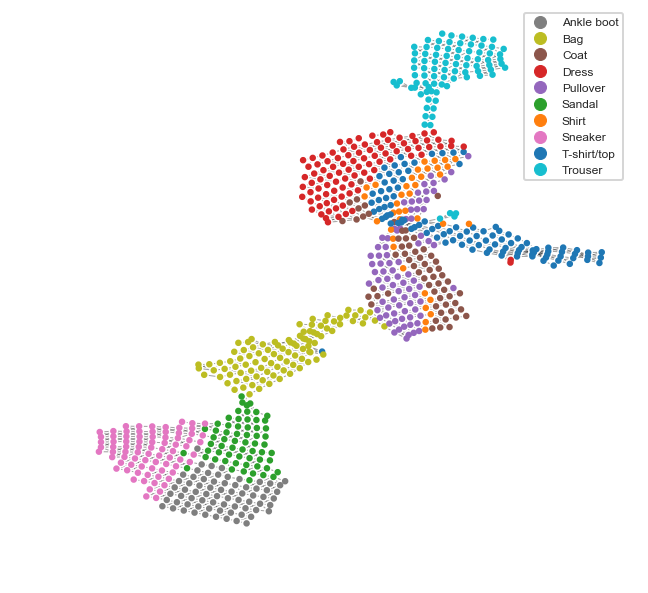

In [100]:
def visualize(cc_sub):

    f, axarr = plt.subplots(1,1, figsize=(10,10))
    visuals.draw_region(cc_sub, classes=mapper_labels, pos=pos, size_base=20, ax=axarr)
#     visuals.draw_region(cc_sub, classes=mapper_labels, sub_region=route_as_graph , pos=pos, ax=axarr[1])
    visuals.add_legend(mapper_lbls)
    if save: plt.savefig(os.path.join(save_root, "digits_pca_lens_reduction.png"), bbox_inches="tight", transparent=True)
        
visualize(nx_graph)


In [53]:
# Show the filtration of the graph

# for each edge, compute the jaccard distance
# look at distribution of jaccard distances
# what happens when we remove all edges with high jaccard distance?
# 

edge_jd = {}

for edge in nx_graph.edges:

    left = nx_graph.nodes[edge[0]]['membership']
    right = nx_graph.nodes[edge[1]]['membership']
    jd = 1 - set(left).intersection(set(right)).__len__() / set(left).union(set(right)).__len__()
    edge_jd[edge] = jd

nx.set_edge_attributes(G=nx_graph, name='dist', values=edge_jd)

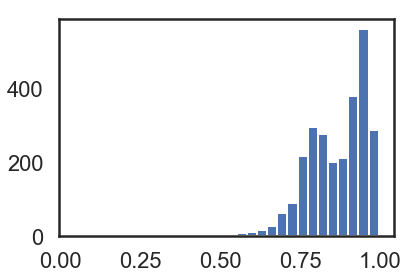

In [54]:
jd_values = list(edge_jd.values())
import matplotlib.pyplot as plt
plt.hist(jd_values, bins=30)
plt.show()

514


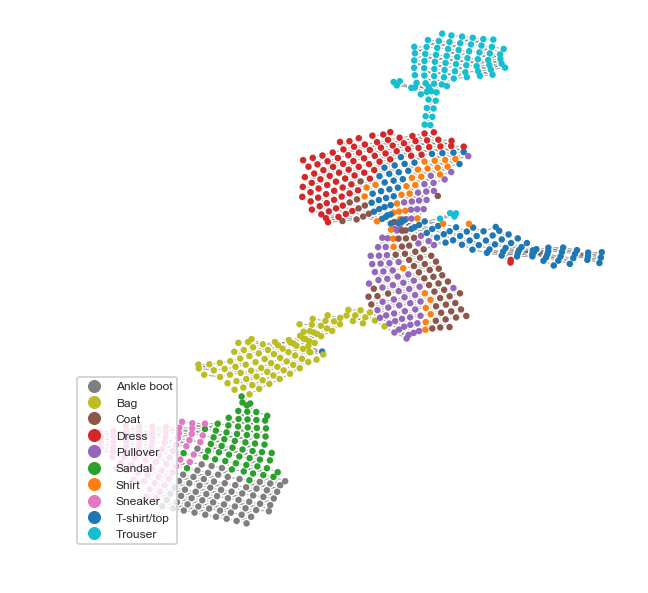

In [55]:
threshold = 0.95
far_edges = [edge for edge in nx_graph.edges if nx_graph.edges[edge]['dist'] >= threshold]
print(len(far_edges))
nx_graph = nx_graph.copy()
nx_graph.remove_edges_from(far_edges)
nx_graph = nx_graph.subgraph(max(nx.connected_components(nx_graph), key=len))

visualize(nx_graph)

# Visualize path between 2 nodes

['cube372_cluster0', 'cube333_cluster0', 'cube294_cluster0', 'cube255_cluster0', 'cube216_cluster0', 'cube177_cluster0', 'cube138_cluster0']


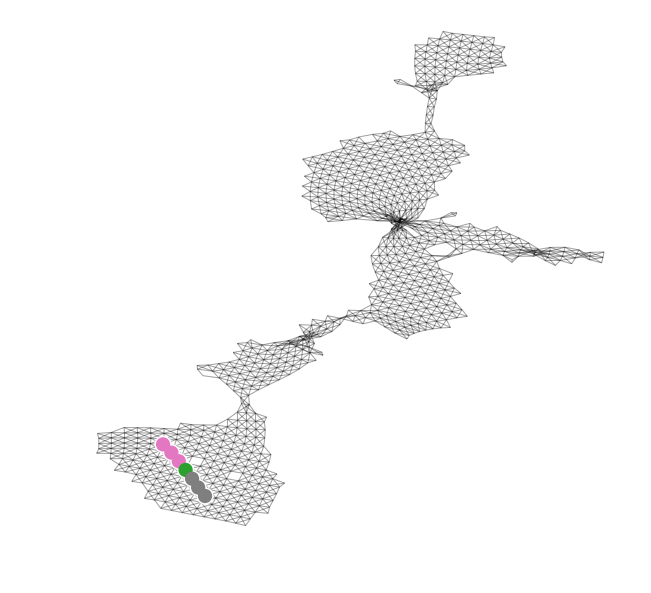

In [101]:
grey = [16, 25, 29]

start = "cube372_cluster0"
end = "cube138_cluster0"
path = nx.shortest_path(cc_sub, source=start, target=end)
print(path)
path_subgraph = nx.subgraph(cc_sub, path)
f, axarr = plt.subplots(1,1, figsize=(10,10))
visuals.draw_region(cc_sub, classes=mapper_labels, sub_region=path_subgraph , pos=pos, ax=axarr)
# visuals.add_legend(mapper_labels)
if save: plt.savefig(os.path.join(save_root, "a_path_in_digits_mapper.png"), bbox_inches="tight", transparent=True)

In [102]:
ntrs = nx.get_edge_attributes(nx_graph, 'dist')
nx.set_edge_attributes(cc_sub, ntrs, 'dist')

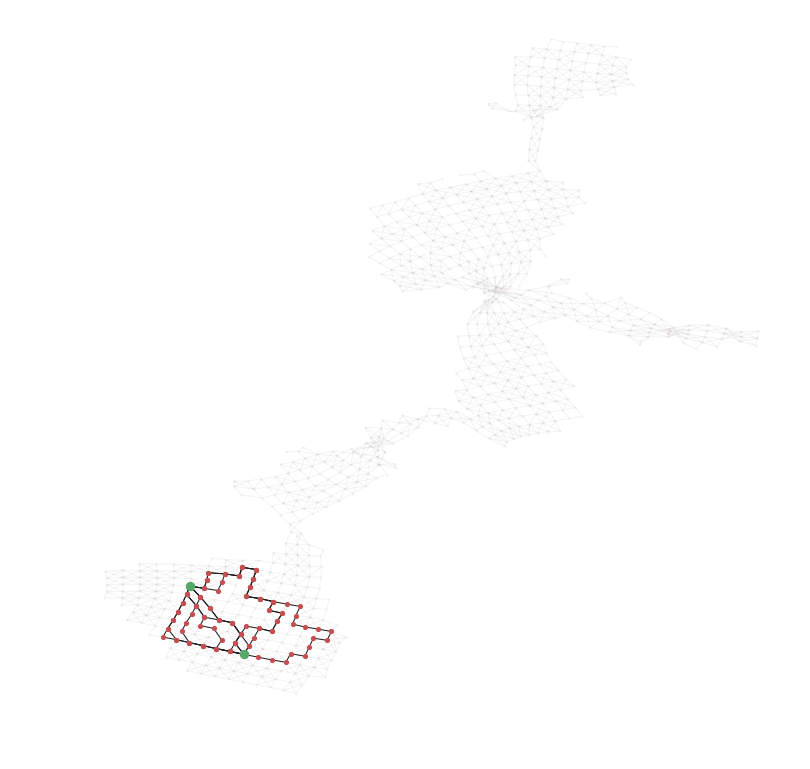

In [103]:
import paths
most_stable, all_stable_paths = paths.most_stable_paths(nx_graph, start, end)
paths.draw.draw_stable_paths(nx_graph, most_stable, start, end, pos=pos)

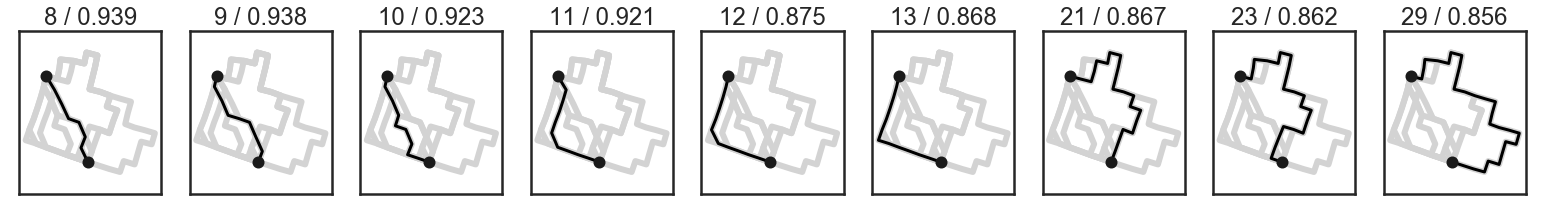

In [104]:
paths.draw.draw_multiples(nx_graph, most_stable, pos=pos)

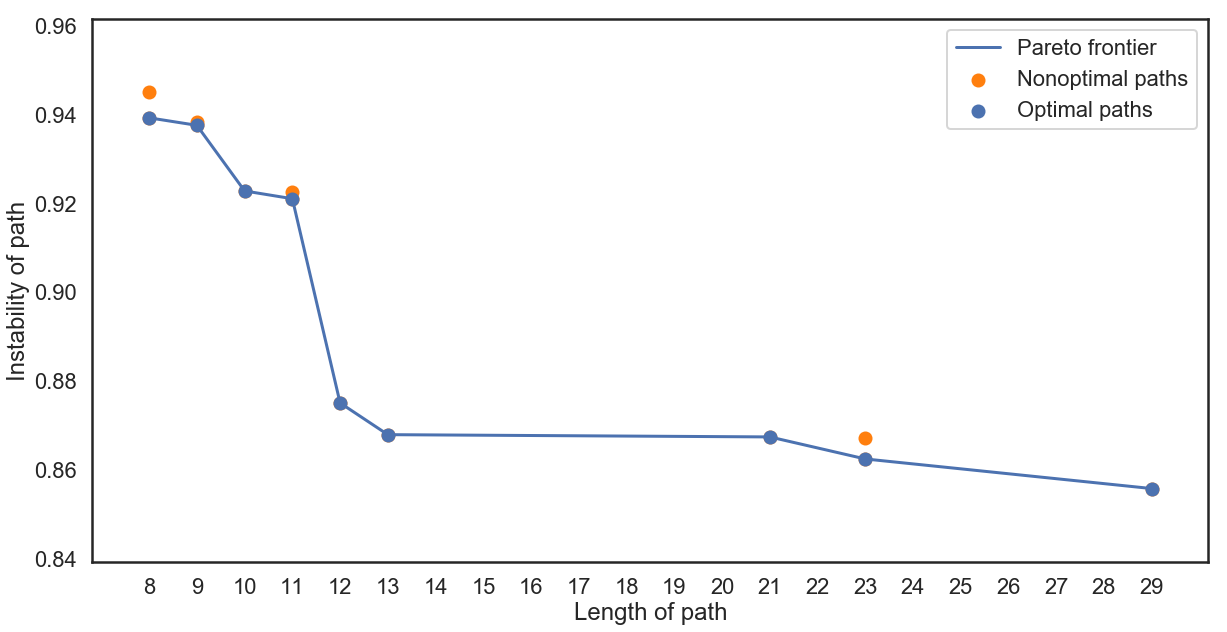

In [105]:
# plt.figure(figsize=(20,8))
paths.draw.plot_pareto(most_stable, all_stable_paths)

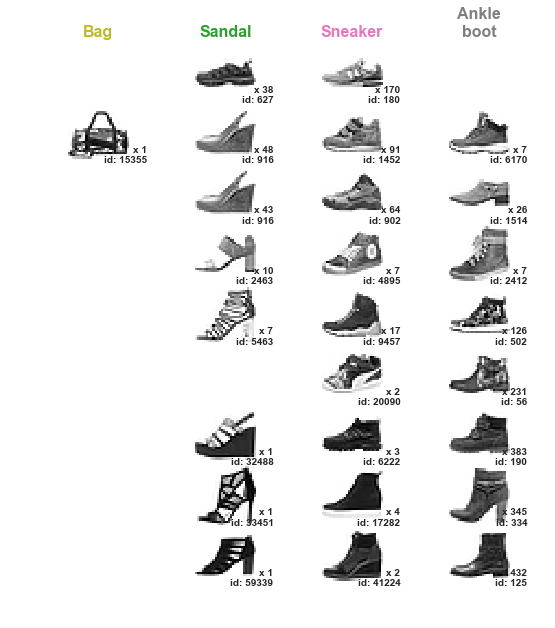

In [74]:
from matplotlib import gridspec
fig = plt.figure(figsize=(20, 10))
outer = gridspec.GridSpec(1, 2)
# visuals.draw_region(cc_sub, classes=mapper_labels, sub_region=path_subgraph, pos=pos, ax=plt.subplot(outer[0]))
visuals.draw_path_grid(cc_sub, mapper_lbls, path, render_func=render, which='nodes', grid=outer[0], fig=fig)
# visuals.draw_path_grid(cc_sub, mapper_lbls, path, render_func=render, which='edges', grid=outer[1], fig=fig)
if save: plt.savefig(os.path.join(save_root, "route_path_visual_reduced.png"), bbox_inches="tight", transparent=True)

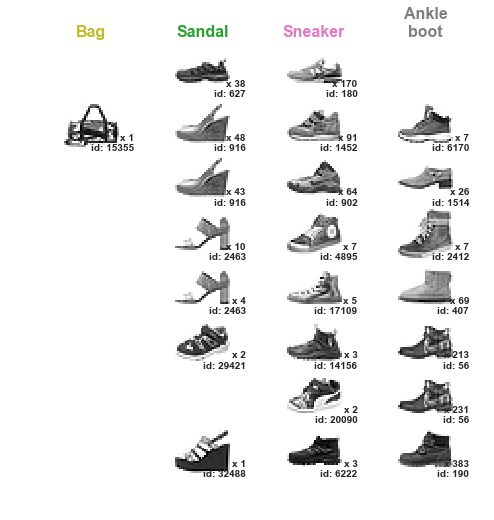

In [106]:
fig = plt.figure(figsize=(8, 8))
visuals.draw_path_grid(cc_sub, mapper_lbls, most_stable[8][0], render_func=render, which='nodes', fig=fig)

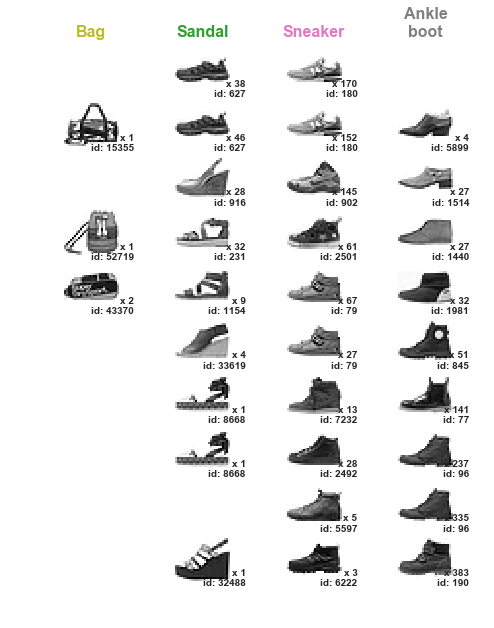

In [108]:
fig = plt.figure(figsize=(8, 10))
visuals.draw_path_grid(cc_sub, mapper_lbls, most_stable[10][0], render_func=render, which='nodes', fig=fig)

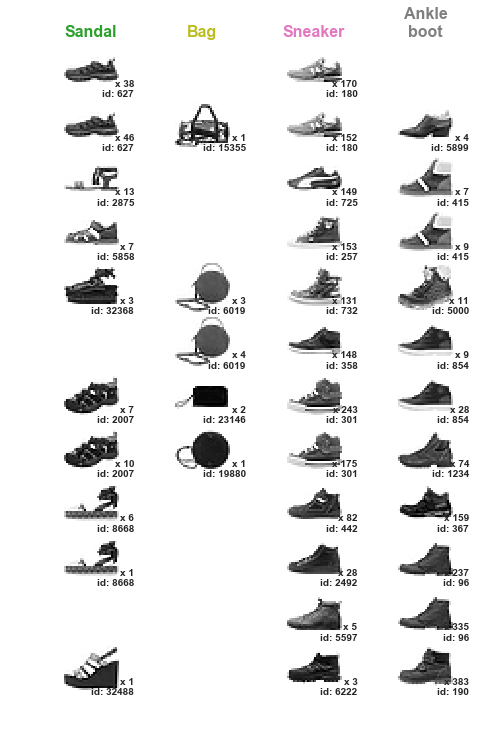

In [111]:
fig = plt.figure(figsize=(8, 12))
visuals.draw_path_grid(cc_sub, mapper_lbls, most_stable[12][0], render_func=render, which='nodes', fig=fig)

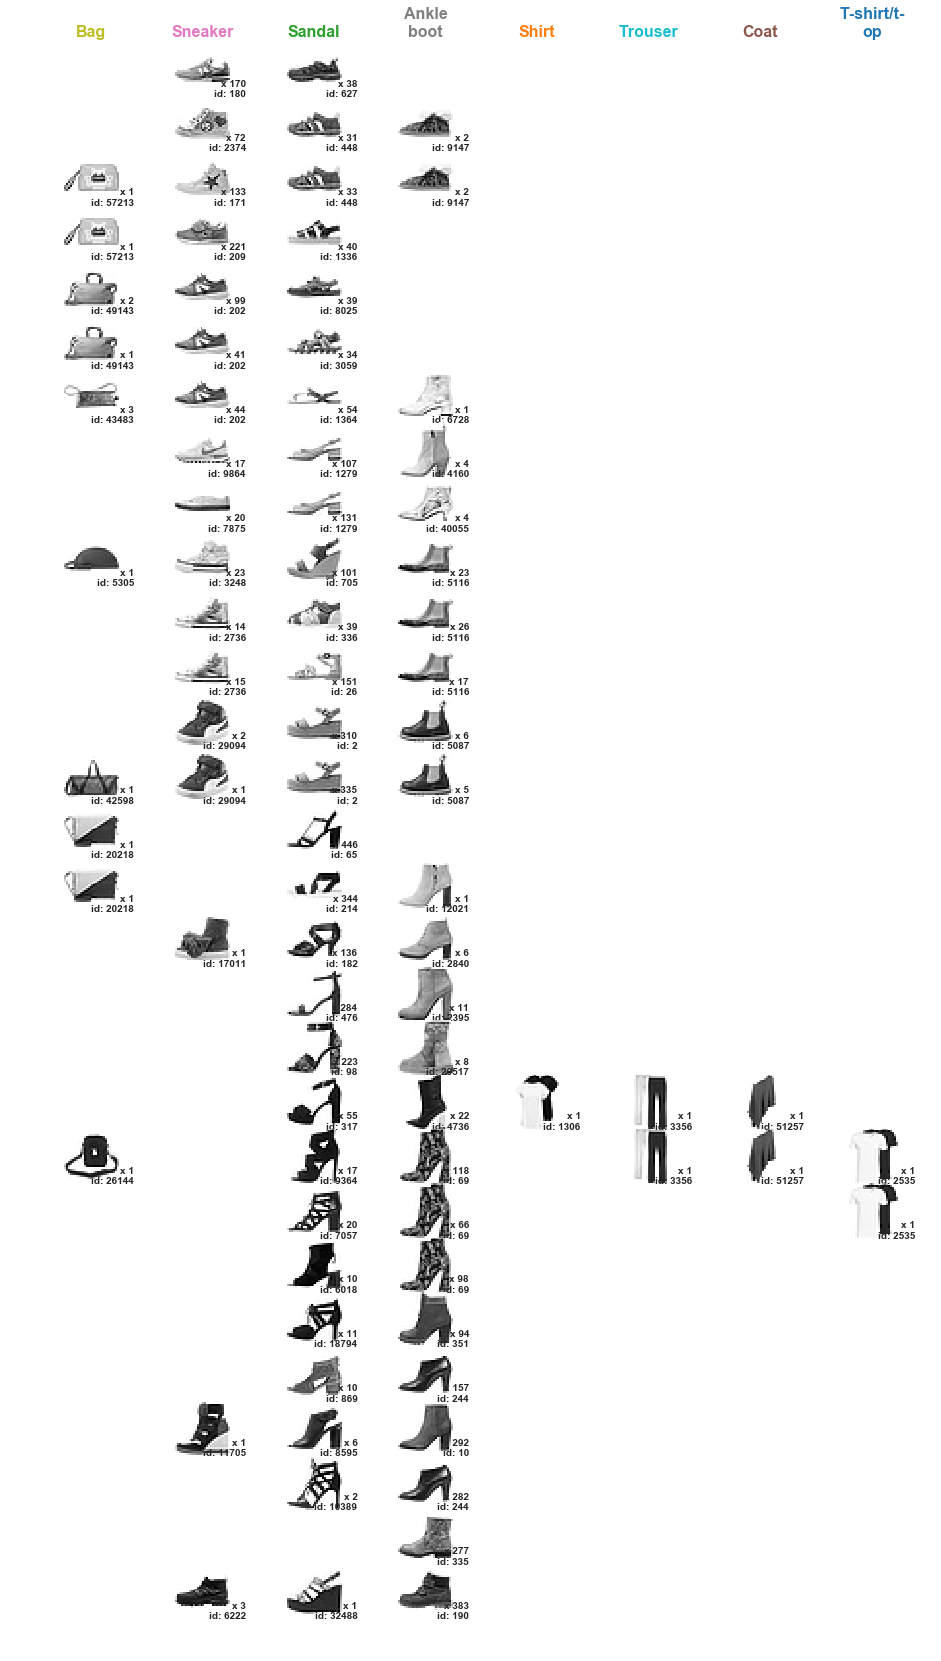

In [110]:
fig = plt.figure(figsize=(16, 29))
visuals.draw_path_grid(cc_sub, mapper_lbls, most_stable[29][0], render_func=render, which='nodes', fig=fig)